In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"
pd.options.display.max_columns = None
np.random.seed(0)

In [2]:
data = pd.read_pickle("../Data/Data.pickle")

data["Month"] = data.index.month
data["Week"] = data.index.week
data["Day"] = data.index.dayofweek

Let's see how our [machine Learning](https://www.kamwithk.com/machine-learning-field-guide-ckbbqt0iv025u5ks1a7kgjckx), [project planning](https://www.kamwithk.com/insight-is-king-how-to-get-it-and-avoid-pitfalls-ckbjfohz201ujzqs1lwu5l7xd) and [essential coding tools](https://www.kamwithk.com/the-complete-coding-practitioners-handbook-ck9u1vmgv03kg7bs1e5zwit2z) can be brought to life in a real-world project!
Today we're going through how we can predict how much energy we use daily using temperature data.
We start here with **importing and cleaning data, before graphing and depicting the story of our energy usage and finally modelling it**.

This is the last section, where we take our [cleaned data](https://www.kamwithk.com/machine-learning-energy-demand-prediction-project-part-1-data-cleaning-ckc5nni0j00edkss13rgm75h4?guid=14f9ef0e-cd44-4f28-b588-fec4b33b41cf) and our [understanding of temperature and energy](https://www.kamwithk.com/machine-learning-energy-demand-prediction-project-part-2-storytelling-using-graphs-ckcecai0i006xbrs1hcase6f6) to develop a predictive model. Feel free to code along, the full project is on [GitHub](https://github.com/KamWithK/Temp2Enrgy).

# The story
We wake up in the mornings, turn on the heater/air conditioner, find some yogurt from the fridge for breakfast, shave, turn on a computer, get the music rolling and finally get to work.
These tasks all have one thing in common - they use power!
Our heavy reliance on electricity makes it crucial to estimate how much energy we'll need to generate each day.


But, fear not if this seems challenging.
We will take it one step at a time.
At each stage linking back to how it relates to our [ML field guide](https://www.kamwithk.com/machine-learning-field-guide-ckbbqt0iv025u5ks1a7kgjckx).


We already [found, cleaned](https://www.kamwithk.com/machine-learning-energy-demand-prediction-project-part-1-data-cleaning-ckc5nni0j00edkss13rgm75h4?guid=14f9ef0e-cd44-4f28-b588-fec4b33b41cf), [visualised and interpreted our energy usage](https://www.kamwithk.com/machine-learning-energy-demand-prediction-project-part-2-storytelling-using-graphs-ckcecai0i006xbrs1hcase6f6) 😊.
Now we can translate this into a model able to predict how much energy we use!
We start our journey of right where we left off taking a deep look into how we can remove annual increases/decreases in energy usage caused by economic and population growth.
This is a hard problem, so to simplify we break down the energy demand time series into separate parts (which we graph).
The three important *components* of the time series are *overall increasing, decreasing and stable trends*, *seasonal repetitive changes* and other *random residual noise*.
Research into time series indicates that we can *detrend* our data through a process called *differentiating*, where we subtract the previous $n$'th value at each point.


With data in a clean and predictable state, our minds are at ease and we can move onto quickly dividing up the dataset and creating a *decision tree model* for each state.
We'll find out what variables (specifically hyperparameters) effect it and then use grid search to find the best values.

We can then judge how well they fair, and contemplate how they could improve.
Then, finally, we can honour the project by showing it off to everyone we know 🥳!

# The Epochs
## Removing trends/seasonality
Let's begin by clearly explaining our situation.
As mentioned before, this is achieved through graphs which break down our time series!
They help us visually interpret precisely what needs to be removed/modified.

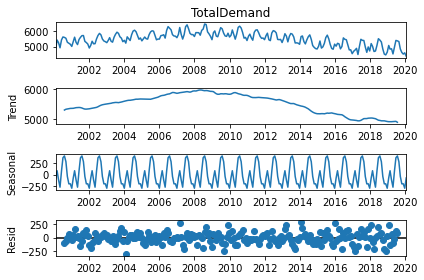

In [3]:
seasonal_decompose(data.groupby("Region").get_group("VIC")["TotalDemand"].resample("M").mean(), model="additive").plot();

At the top, we see the full graphs, and below it *trends* (the increase/decrease of values with time), *seasonality* (the repeating pattern of increasing and then decreasing values) and *residuals* (everything else which is present, but more so random since it doesn't seem to repeat itself).


We just decomposed Victoria's energy demand here, so it isn't completely representative of what we'll remove, but close enough to remind us of the problem.
What we want is to eliminate that gradual long-term increasing/decreasing trend.
This is normally done through *diffing* our data (subtract $n$'th previous value from each entry).
We'll subtract the value half a year ago since our trends happen in the long-run.
Since we do it separately on each state, we first have to order the data by region and time (we can reverse this after).

In [4]:
# Sort dataframe by region so groupby's output can be combined and used for another column
data.sort_values(by=["Region", "Date"], inplace=True)
data["AdjustedDemand"] = data.groupby("Region")["TotalDemand"].diff(8544)
all([region[1].sort_index().index.equals(region[1].index) for region in data.groupby("Region")])
data.sort_index(inplace=True)

True

When we graph the original total demand we find that it was not stationary, however, when we overlay the new adjusted version it varies up and down across one straight line (implying that the trend has been removed).

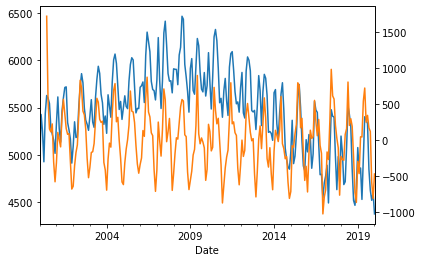

In [5]:
data.groupby("Region").get_group("VIC")["TotalDemand"].resample("M").mean().plot();
data.groupby("Region").get_group("VIC")["AdjustedDemand"].resample("M").mean().plot(secondary_y=True);

To ensure we're right, we can graph the distribution of temperature against energy, and see how it changes with time.
We can see that the graphs become tighter, showing how that the number of energy values for a certain temperature has been reduced (good)!

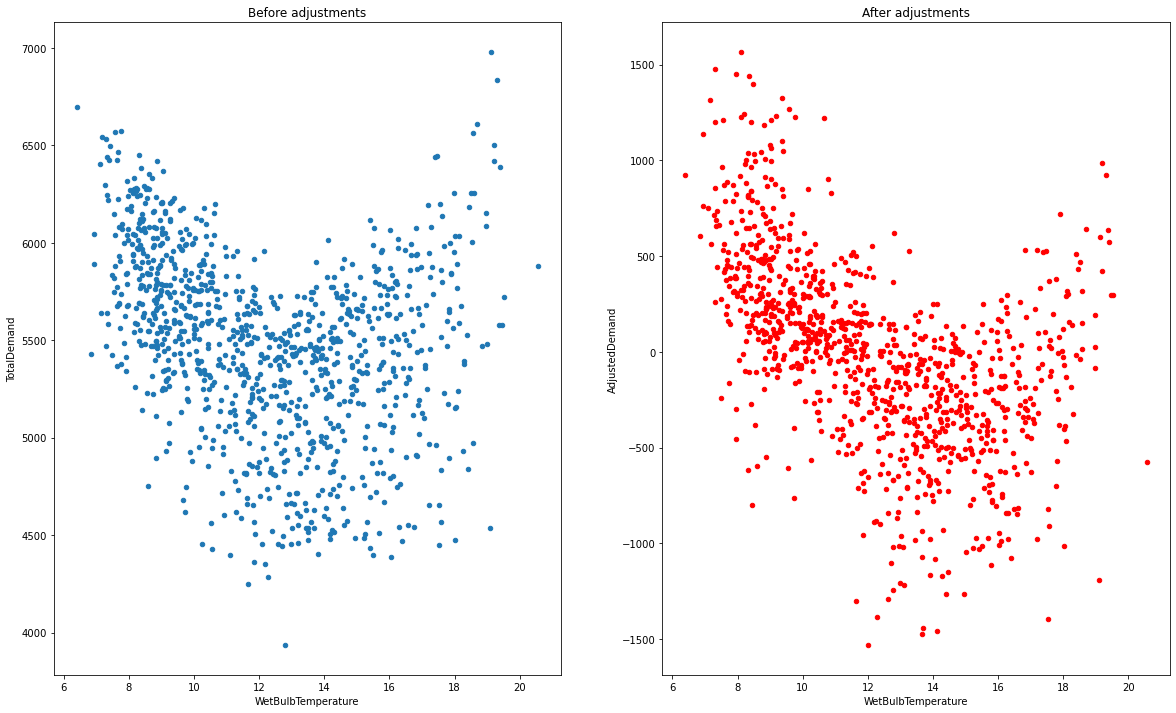

In [6]:
fix, axes = plt.subplots(ncols=2, figsize=(20, 12))
data.groupby("Region").get_group("VIC").resample("W").mean().plot(x="WetBulbTemperature", y="TotalDemand", kind="scatter", ax=axes[0], title="Before adjustments");
data.groupby("Region").get_group("VIC").resample("W").mean().plot(x="WetBulbTemperature", y="AdjustedDemand", kind="scatter", ax=axes[1], title="After adjustments", color="red");

## Divide up data
There's one thing everyone knows by now - we have a lot of data.
So now we have to split it up and be 100% confident that it's what we're looking for.
The default distribution of 75% of data for training and 25% for testing is good enough for our purpose.


Not everyone has a monstrously powerful computer, so to ensure it's easy and fast to train our model (useful to quickly see how our model fares, try changing a few things and retrain) we'll only predict the overall energy usage every day (instead of per 30 minutes).
This should decrease the effect of any present outliers too!


Whilst testing out changes, one thing which will become immediately obvious is that including complete information on time causes overfitting.
This is because there are *only 20 years present*, meaning any information encoded in the year is likely, not generalisable.
To fix this, we can just use integers for the day, week and month number.
Anomalies/outliers should now be relatively rare (hopefully 😲).

In [7]:
resampled_data = data.groupby("Region").resample("D").mean().reset_index("Region").sort_index()
train_data, test_data = train_test_split(resampled_data, shuffle=False)

input_columns = ["WetBulbTemperature", "Month", "Week", "Day"]
output_columns = ["AdjustedDemand"]

train_input_data, train_output_data = train_data[input_columns + ["Region"]], train_data[output_columns + ["Region"]]
test_input_data, test_output_data = test_data[input_columns + ["Region"]], test_data[output_columns + ["Region"]]

## Create and train a model
We have a large selection of models we can use.
We can try and see which ones work (good idea for beginners), but after the long trials, it becomes obvious that simple and fast models like decision trees work just as well as more complex ensemble models like random forests.
Of course, linear models won't work (our data is shaped like a parabola in most cases).


As [mentioned before](https://www.kamwithk.com/machine-learning-field-guide-ckbbqt0iv025u5ks1a7kgjckx#hyperparameter-tuning), we need to find the optimal hyperparameters (how deep and complex our decision tree can become), and grid search is the standard way to do it.
We run [grid search](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) over 5 subsets of our dataset (K-fold cross-validation).
The max depth (how *deep* the tree can grow), along with min sample leaves (minimum end-nodes the tree must-have, which produces shallow trees) and max-leaf nodes (maximum end-nodes the tree is allowed to have, which produces deeper trees) are our hyperparameters (put into a ```paramaters``` array).
We've found these through [reading the decision-tree Scikit Learn documentation](https://scikit-learn.org/stable/modules/tree.html) which has a lot of details on how to use each model (with a few examples)!
Knowing what specific values to try out for each variable comes down to manual testing (try and see what happens).


The ```get_best_model``` function here is responsible for hyperparameter tuning, whilst the ```get_predictions``` one loops through each state and trains a model for it.
Separating different concepts into their own functions/classes is a good way to ensure code clarity, reproducibility and modification.

In [8]:
def get_best_model(test_input: pd.DataFrame, test_output: pd.DataFrame):
    paramaters = {"max_depth": [*range(1, 20), None], "min_samples_leaf": [2, 5, 10, 15], "max_leaf_nodes": [5, 10, 20, None]}
    regressor = DecisionTreeRegressor()
    grid = GridSearchCV(regressor, param_grid=paramaters, n_jobs=1)
    grid.fit(test_input, test_output.values.ravel())
    best_score, best_depth = grid.best_score_, grid.best_params_
    
    return grid, best_score, best_depth

In [9]:
def get_predictions(regressor, test_input, test_output, train_input=None, train_output=None):
    test_predictions = regressor.predict(test_input)
    test_results = pd.DataFrame(test_predictions, columns=output_columns, index=test_input.index)
    test_results = test_data[input_columns].join(test_results)
    
    if type(train_input) != None and type(train_output) != None:
        train_predictions = regressor.predict(train_input)
        train_results = pd.DataFrame(train_predictions, columns=output_columns, index=train_input.index)
        train_results = train_data[input_columns].join(train_results)
        
        return test_results, train_results
    return test_results

In [10]:
models, regressors = [], []

test_predictions, train_predictions = [], []

for region, dataframe in train_data.groupby("Region"):
    # Cross validate to find the best model
    model_input, model_output = dataframe.dropna()[input_columns], dataframe.dropna()[output_columns]
    grid, score, params = get_best_model(model_input, model_output)
    regressors.append(grid)
    models.append(regressors[-1].fit(model_input, model_output.values.ravel()))
    
    print(f"Best {region} model has a score of {score} and best params {params}")
    
    # Get the test data for this specific region
    test_input = test_data.groupby("Region").get_group(region)[input_columns].dropna()
    test_output = test_data.groupby("Region").get_group(region)[output_columns].dropna()
    
    # Generate predictions, obtain and log the final formatted data
    test_results, train_results = get_predictions(regressors[-1], test_input, test_output, model_input, model_output)
    test_predictions.append(test_results)
    train_predictions.append(train_results)

Best NSW model has a score of 0.6673092603240149 and best params {'max_depth': 11, 'max_leaf_nodes': None, 'min_samples_leaf': 15}
Best QLD model has a score of 0.679797201035001 and best params {'max_depth': 11, 'max_leaf_nodes': None, 'min_samples_leaf': 15}
Best SA model has a score of 0.4171236821322447 and best params {'max_depth': 9, 'max_leaf_nodes': None, 'min_samples_leaf': 10}
Best TAS model has a score of 0.7609030948185131 and best params {'max_depth': 15, 'max_leaf_nodes': None, 'min_samples_leaf': 15}
Best VIC model has a score of 0.6325583799486684 and best params {'max_depth': 10, 'max_leaf_nodes': None, 'min_samples_leaf': 15}


We can see that Tasmania fares quite well, with a score just under 80%.
This makes sense, as Tasmania started with very little trend, meaning the should be a higher correlation between temperature and energy.
Queensland, New South Wales and Victoria aren't all too bad either, with scores between 60%-70%!

If we look at the `max_depth`, we can also tell that our models aren't as complex as they could be.

## Visualise performance
To judge how well our model fairs, we create and analyse plots of energy and temperature.
We start by seeing the correlation of energy and temperature for each state (the predictions are blue, and the real values are red).
We can see that the model isn't perfect and doesn't always predict the right values, but is pretty decent given the small number of features we are using.

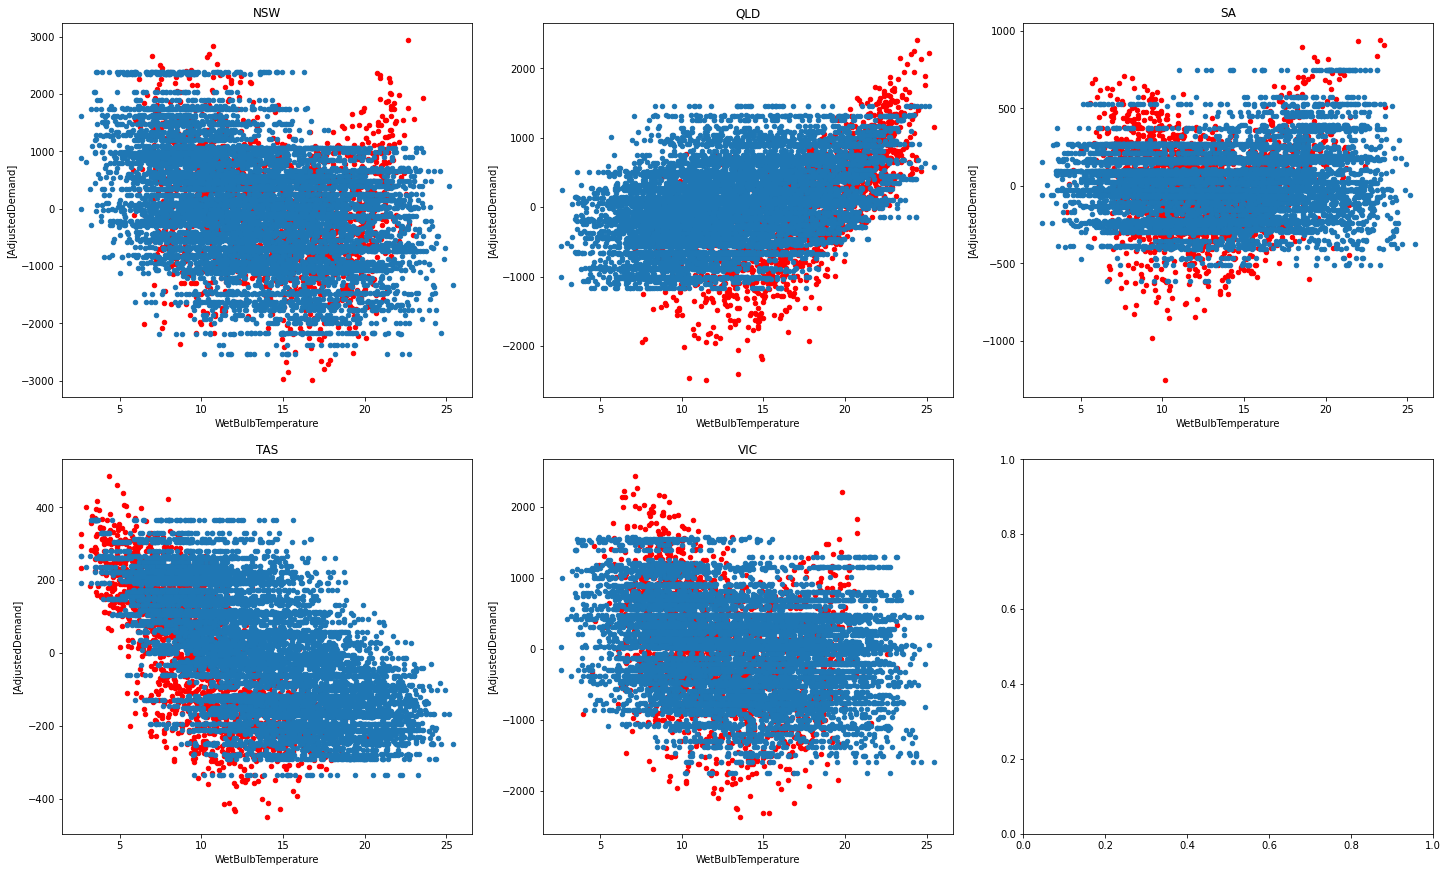

In [11]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 12), constrained_layout=True)
counter = [0, 0]
        
for region, region_data in test_data.groupby("Region"):
    region_data.plot(ax=axes[counter[0], counter[1]], x="WetBulbTemperature", y=output_columns, kind="scatter", color="red", title=region)
    
    if counter[1] < 2: counter[1] += 1
    elif counter[1] == 2: counter[1] = 0; counter[0] += 1

counter = [0, 0]

for region_data in test_predictions:
    region_data.plot(ax=axes[counter[0], counter[1]], x="WetBulbTemperature", y=output_columns, kind="scatter")
    
    if counter[1] < 2: counter[1] += 1
    elif counter[1] == 2: counter[1] = 0; counter[0] += 1
        
pass;

Majority of the time the predictions align with the actual data, but it tends to be off at times.
We can see that Tasmania and Queensland are quite well done (explaining their high performance).
It looks like their graphs are more linear and less curved, which may be why they outperform other states.

We can move onto looking at the energy time series now.

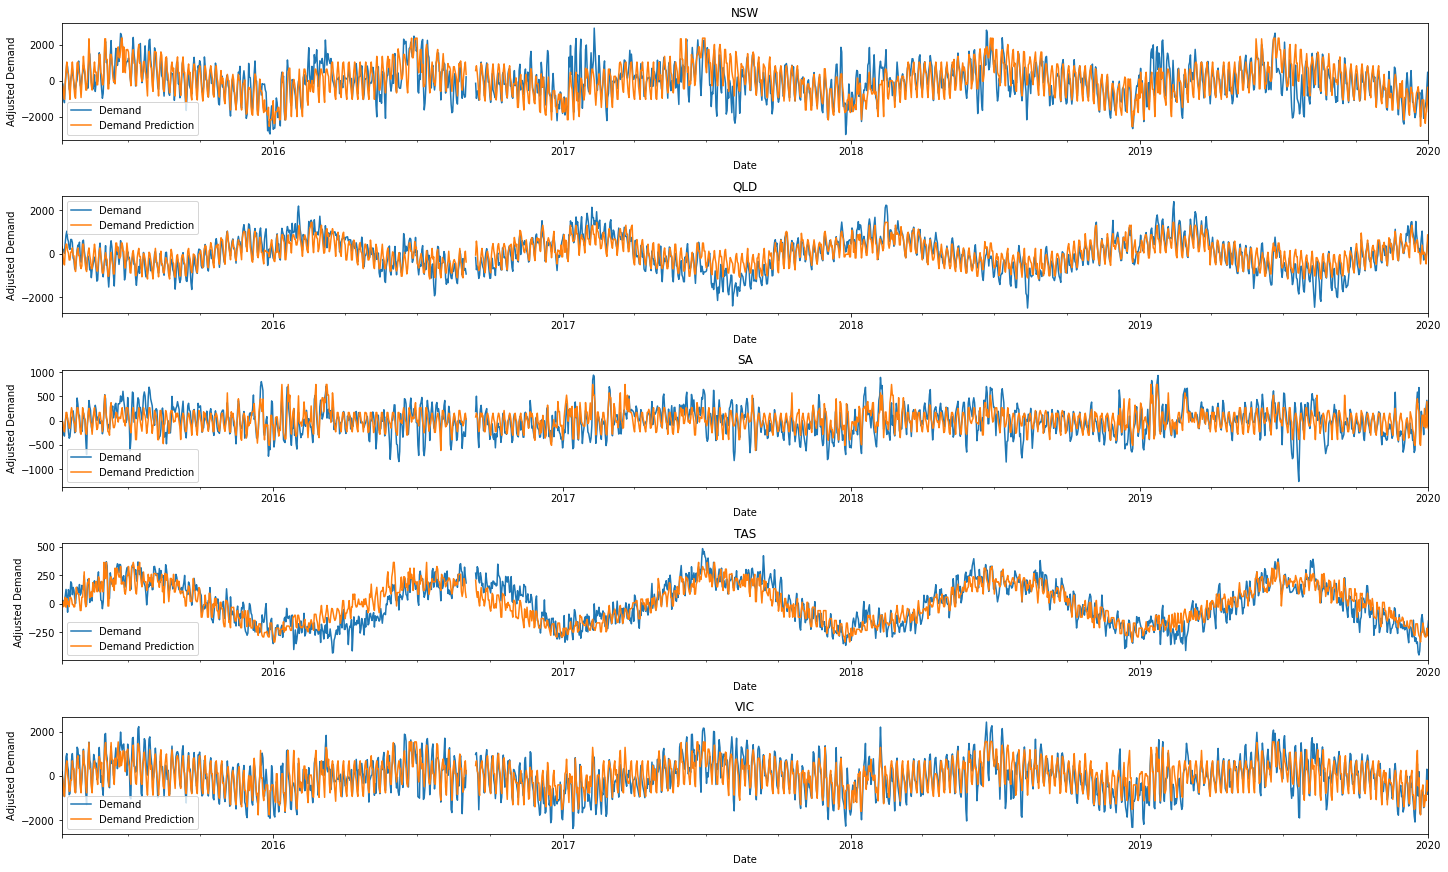

In [12]:
fig, axes = plt.subplots(nrows=5, figsize=(20, 12), constrained_layout=True)
        
for i, (region, region_data) in enumerate(test_data.groupby("Region")):
    region_data[output_columns].plot(ax=axes[i], title=region)
    test_predictions[i][output_columns].plot(ax=axes[i])
    axes[i].set_ylabel("Adjusted Demand")
    axes[i].legend(["Demand", "Demand Prediction"])
pass;

We can see that the general ups and downs are *mostly* found and predicted across time.
The magnitude of the energy demand is also forecasted relatively well!
This is incredible given that we *only need temperature and dates/times* to generate our predictions!

To be more critical we can see that around halfway through most years, our energy predictions derail.
The model for Tasmania also seems to particularly struggle in 2017.
The temporary half-yearly blunders seem more severe in New South Wales and South Australia.
To get a feel for how bad these problems may be, we can just plot 2019.
It'll show that our predicts are pretty decent!

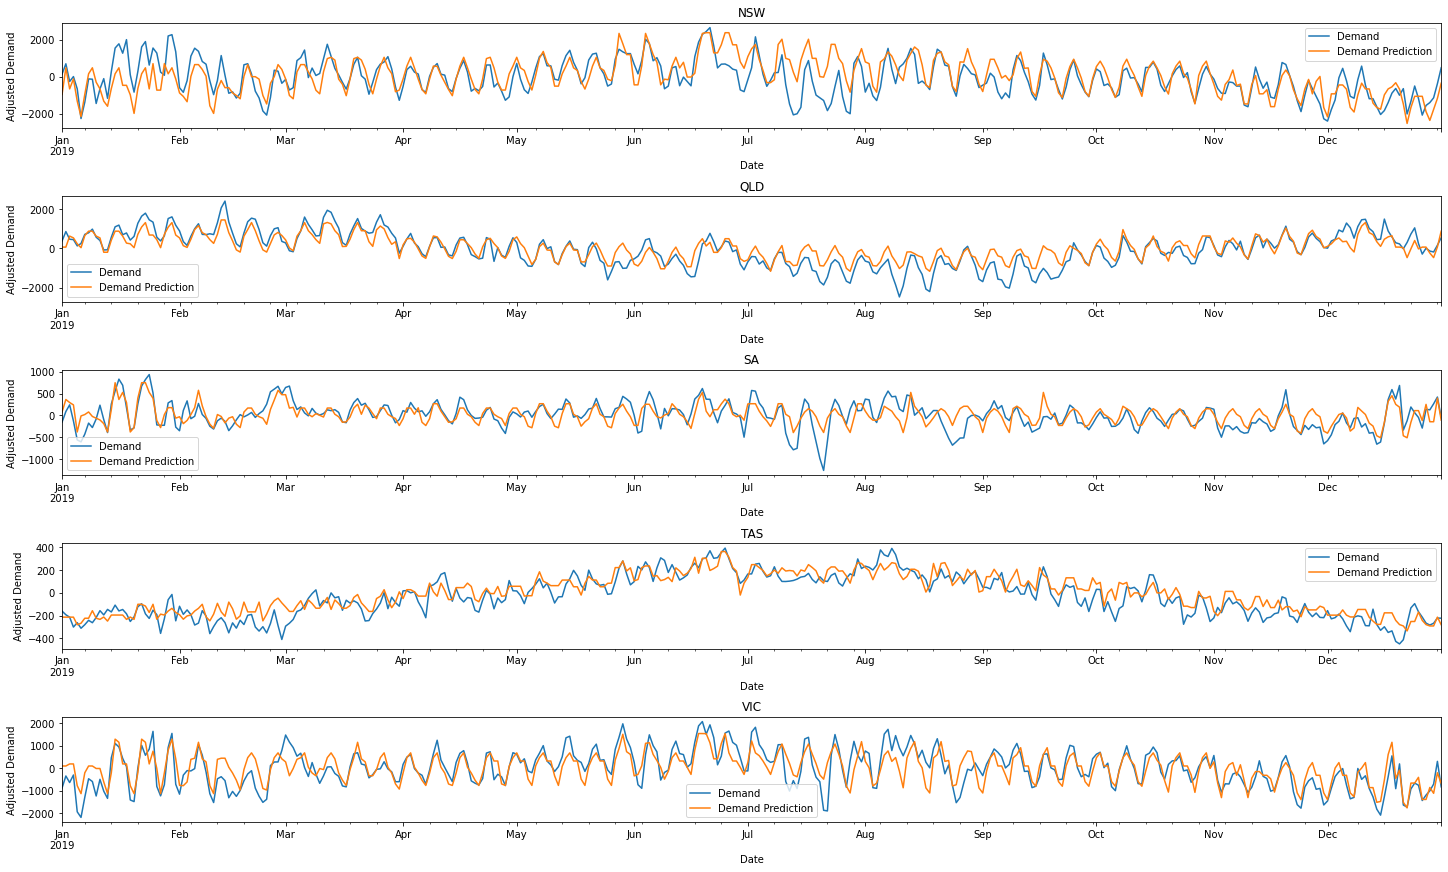

In [13]:
fig, axes = plt.subplots(nrows=5, figsize=(20, 12), constrained_layout=True)

for i, (region, region_data) in enumerate(test_data.groupby("Region")):
    region_data[output_columns]["2019"].plot(ax=axes[i], title=region)
    test_predictions[i][output_columns]["2019"].plot(ax=axes[i])
    axes[i].set_ylabel("Adjusted Demand")
    axes[i].legend(["Demand", "Demand Prediction"])
    
pass;

## Conclusions
We've come a long way 🤠!
We started off knowing little to nothing about energy, and now have a solid understanding of what effects it.
To start off we cleaned the data (an arduous process, but worth it), then created a bunch of graphs which illustrated patterns and trends in temperature and energy demand.
Energy demand was is greatest when the temperature is extremely high or low (too cool or too warm and we freak out 🤣).
We now know that 9 am to 6 pm is active high energy time too!

Being able to create and train a working model to model these changes though, it's pushed us to a new level.
Everything we saw and labelled before, our model can predict.
We even know how to improve the model, by collecting data on population, technological advancements and economic activity.
All in all, if there's one thing to take from this, it is that **graphs and conceptual knowledge are the building blocks for creating and understanding a model**!